(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Stack Overflow

## Introduction 

In this assignment, we will look at some posts on Stack Overflow during the year of 2015 and measure the similarity of users by looking at the types of questions they answer. We will also analyze the creation dates of questions.

## Step 0. Preparation

Before we start working on the notebook, let's make sure that everything is setup properly. You should have downloaded and installed
* [Anaconda](https://store.continuum.io/cshop/anaconda/)
* [Git](http://git-scm.com/downloads)

If you are working from the undergraduate lab (on a linux machine) these are both installed, but you need to follow the instructions [from here](https://github.com/datascience16/lectures/blob/master/Lecture2/Getting-Started.ipynb).



## Step 1. Getting the data

Let's make a sample request to retrieve the questions posted on Stack Exchange on the first day of 2015. Documentation of the Stack Exchange API can be found [here](https://api.stackexchange.com/docs).

In [ ]:
import requests

start_time = 1420070400 # 01-01-2015 at 00:00:00
end_time   = 1420156800 # 01-02-2015 at 00:00:00

response = requests.get("https://api.stackexchange.com/2.2/questions?pagesize=100" +
                        "&fromdate=" + str(start_time) + "&todate=" + str(end_time) +
                        "&order=asc&sort=creation&site=stackoverflow")
print response

All dates in the Stack Exchange API are in [unix epoch time](https://en.wikipedia.org/wiki/Unix_time). The format for the request string is specified [here](https://api.stackexchange.com/docs/questions).

We can try to print the response that Stack Exchange returns.

In [ ]:
print response.text

It is not possible to read the raw response. Instead, we need to decode the raw response as JSON and use the `json` library to print it.

In [ ]:
import json

print json.dumps(response.json(), indent=2)

Now we can easily see that the response consists of a list of question items. For each of these items, we get information about its attributes such as its `creation_date`, `answer_count`, `owner`, `title`, etc.

Notice that has_more is true. To get more items, we can [request the next page](https://api.stackexchange.com/docs/paging).

-----------------

## Step 2. Parsing the responses

In this section, we practice some of the basic Python tools that we learned in class and the powerful string handling methods that Python offers. Our goal is to be able to pick the interesting parts of the response and transform them in a format that will be useful to us.

First let's isolate the creation_date in the response. Fill in the rest of the ```print_creation_dates_json()``` function that reads the response and prints the creation dates. Notice that a JSON object is basically a dictionary. **(5 pts)**

In [ ]:
def print_creation_dates_json(response):
    """
    Prints the creation_date of all the questions in the response.
    
    Parameters:
        response: Response object
    """
    data = dict(response.json())['items']
    for entry in data:
        print entry['creation_date']

Write the code that calls the ```print_creation_dates_json()``` function to print out all the creation dates of questions posted on the first day in 2015. Please be aware of Stack Exchange's [rate limit](https://api.stackexchange.com/docs/throttle). **(5 pts)**

In [ ]:
print_creation_dates_json(response)

Due to time constraints, we have downloaded the [data dump](http://cs-people.bu.edu/kzhao/teaching/stackoverflow-posts-2015.tar.gz) for Stack Overflow's posts in 2015. Note that this file is 10GB. If you don't have space on your computer, you can download it into `/scratch` on one of the machines in the undergrad lab or you can download it onto a USB. You may also want to work with a subset of this data at first, but your solution should be efficient enough to work with the whole dataset. For example, if you call `read()` on this file, you will get a `MemoryError`.

Write a function to parse out the questions posted in 2015. These are posts with `PostTypeId=1`. Make a `pandas DataFrame` with 4 columns: `Id`, `CreationDate`, `OwnerUserId`, and the first tag in `Tags`. Save the `DataFrame` to a file named `question_dataframe.csv`. **(10 pts)**

In [3]:
from lxml import etree
import csv

def parse_to_dataframe(): # takes a little over 4 minutes to run on my system
    data = [['Id', 'CreationDate', 'OwnerUserId', 'Tag']] # header row
    
    post_id = ''
    c_date = ''
    user_id = ''
    tag = ''
    filename = 'stackoverflow-posts-2015.xml'
    context = etree.iterparse(filename, events=('end',)) # iterate node by node

    for event, elem in context:
        try:
            if elem.attrib['PostTypeId'] == '1': # is a question post, may not exist
                user_id = elem.attrib['OwnerUserId'] # may not exist
                tag = elem.attrib['Tags'].split('>')[0][1:] # parse for first tag
                post_id = elem.attrib['Id']
                c_date = elem.attrib['CreationDate']
                data += [[post_id, c_date, user_id, tag]] # add column
        except KeyError: # PostTypeId or OwnerUserId do not exist
            continue

    with open('question_dataframe.csv', 'w') as f: # write question data to csv
        writer = csv.writer(f)
        writer.writerows(data)

In [1]:
import pandas

question_df = pandas.read_csv('question_dataframe.csv')
print question_df

               Id             CreationDate  OwnerUserId             Tag
0        27727385  2015-01-01T00:00:58.253      3210431             php
1        27727388  2015-01-01T00:01:43.673       868779      apache-pig
2        27727391  2015-01-01T00:02:32.123      4372672             ios
3        27727393  2015-01-01T00:02:57.983      2482149      sql-server
4        27727394  2015-01-01T00:03:31.337      4263870             php
5        27727396  2015-01-01T00:04:01.407      4409381         android
6        27727406  2015-01-01T00:05:03.773       875317              c#
7        27727407  2015-01-01T00:05:27.167       821742            java
8        27727408  2015-01-01T00:05:34.733      2595033              c#
9        27727409  2015-01-01T00:06:17.720      1815395          apache
10       27727410  2015-01-01T00:06:41.067       541091           mysql
11       27727414  2015-01-01T00:07:28.747      1210038      javascript
12       27727418  2015-01-01T00:07:39.243      3674356         

-----------------

## Step 3. Putting it all together

We are now ready to tackle our original problem. Write a function to measure the similarity of the top 1000 users with the most answer posts. Compare the users based on the types of questions they answer. We will categorize the questions by looking at the first tag in each question. You may choose to implement any one of the similarity/distance measures we discussed in class. Document your findings. **(30pts)**

Note that answers are posts with `PostTypeId=2`. The ID of the question in answer posts is the `ParentId`.

You may find the [sklearn.feature_extraction module](http://scikit-learn.org/stable/modules/feature_extraction.html) helpful.

In [13]:
from sklearn.feature_extraction import DictVectorizer
from lxml import etree
import time

def measure_similarity(df=question_df): # takes about 7 minutes to run on my system
    
    parent_id = ''
    user_id = ''
    
    user_answers = dict() # dictionary of dictionaries to keep track of tags by user
    filename = 'stackoverflow-posts-2015.xml'
    context = etree.iterparse(filename, events=('end',)) # iterate node by node

    for event, elem in context:
        try:
            if elem.attrib['PostTypeId'] == '2': # answer_post
                user_id = elem.attrib['OwnerUserId'] # may not exist, need try block
                parent_id = int(elem.attrib['ParentId'])
                if user_id in user_answers:
                    user_answers[user_id] += [parent_id] # add parent id
                else:
                    user_answers[user_id] = [parent_id] # add new list with parent id
        except: # PostTypeId or OwnerUserId do not exist, or question was asked before 2015
            continue

    # clean up user_answers and sort to top 1000
    user_answers = user_answers.items()
    user_answers.sort(key=lambda x:len(x[1]), reverse=True) # sort by length value, not key
    user_answers = user_answers[:1000] # get top 1000 users
    
    # preprocess tags to dictionary for significant lookup time reduction
    tags = dict()
    for i in range(len(df['Tag'])):
        tags[df['Id'][i]] = df['Tag'][i]
    
    # create list of dictionaries of tags for each user
    user_list = ['' for i in range(len(user_answers))]
    tag_list = [{} for i in range(len(user_answers))]
    for i in range(len(user_answers)):
        user_list[i] = user_answers[i][0] # keep track of users
        for parent_id in user_answers[i][1]:
            try: # in case question asked before 2015 and there is no tag
                tag = tags[parent_id] # grab the tag
                tag_list[i][tag] = tag_list[i].get(tag, 0) + 1
            except:
                continue
    
    # convert to integer matrix for analysis
    vec = DictVectorizer()
    X = vec.fit_transform(tag_list).toarray() # integer vectors of tag count per user
    y = vec.get_feature_names() # tag label of each index in vector
    
    return user_list, X, y

user_list, X, y = measure_similarity()

Let's plot a subset of the distance matrix. Order the pairwise distance in your distance matrix (excluding the entries along the diagonal) in increasing order and pick user pairs until you have 100 unique users. See [Lecture 3](https://github.com/datascience16/lectures/blob/master/Lecture3/Distance-Functions.ipynb) for examples. **(10 pts)**

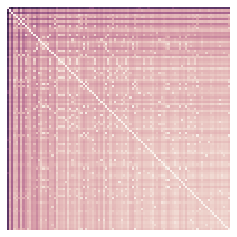

In [14]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
%matplotlib inline

euclidean_dists = metrics.euclidean_distances(X)
sns.heatmap(euclidean_dists[:100, :100], xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

Next, let's create some time series from the data. Look at the top 100 users with the most question posts. For each user, your time series will be the `CreationDate` of the questions posted by that user. You may want to make multiple time series for each user based on the first tag of the questions. Compare the time series using one of the methods discussed in class. Document your findings. **(30 pts)**

You may find the [pandas.DataFrame.resample module](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) helpful.

In [2]:
from datetime import datetime, timedelta
from copy import deepcopy

def dtw_dist(list1, list2): # dynamic time warping distance
    d = {}
    
    for i in range(len(list1)):
        d[(i, -1)] = float('inf')
    for i in range(len(list2)):
        d[(-1, i)] = float('inf')
    d[(-1, -1)] = 0
    
    distance = 0
    for i in range(len(list1)):
        for j in range(len(list2)):
            distance = (list1[i] - list2[i])**2
            d[(i, j)] = distance + min(d[(i-1, j)], d[(i, j-1)], d[(i-1, j-1)])
            
    return pow(d[(len(list1)-1, len(list2)-1)], .5)
    
user_questions = dict()

user_id = ''
date = None

for i in range(len(question_df['Tag'])):
    user_id = question_df['OwnerUserId'][i]
    date = datetime.strptime(question_df['CreationDate'][i][:10], '%Y-%m-%d') # parse to python datetime object
    if user_id in user_questions:
        user_questions[user_id] += [date]
    else:
        user_questions[user_id] = [date]
    
# clean up user_questions and sort to top 100
user_questions = user_questions.items()
user_questions.sort(key=lambda x:len(x[1]), reverse=True) # sort by length value, not key
user_questions = user_questions[:100] # get top 100 users

# create 365 day long timeseries index dictionary
date_index = dict()
base = datetime.strptime('2015-01-01', '%Y-%m-%d')
all_2015 = [base + timedelta(days=i) for i in range(365)]
for i in range(365):
    date_index[all_2015[i]] = i
    
# make y axis of time series for each user
user_ids = [] # final list for user_ids
user_timeseries = [] # final list for user 365-day timeseries
global_user_y_axis = [0 for i in range(365)] # used for deep copy
for i in range(100):
    user_y_axis = deepcopy(global_user_y_axis)
    for date in user_questions[i][1]:
        user_y_axis[date_index[date]] += 1 # increment index of date, represents answer on that day
    user_ids += [user_questions[i][0]] # add user_id to final list
    user_timeseries += [user_y_axis] # add time series to final list
    
# make distance matrix
matrix = [[0]*100 for i in range(100)]
for i in range(100):
    for j in range(100):
        if i == j:
            continue
        else:
            if matrix[j][i] == 0:
                matrix[i][j] = dtw_dist(user_timeseries[i], user_timeseries[j])
            else:
                matrix[i][j] = matrix[j][i]

Plot the 2 most similar and the 2 most different time series. **(10 pts)**

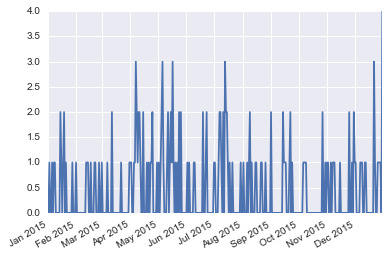

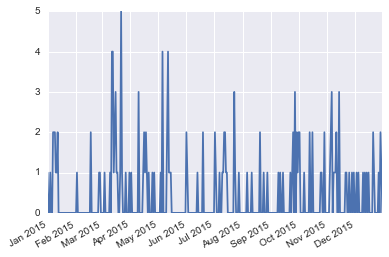

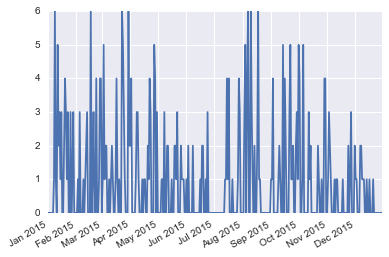

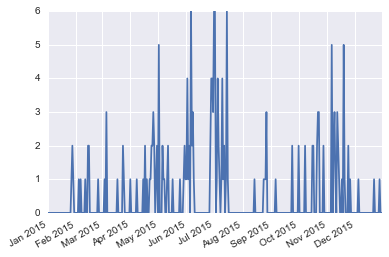

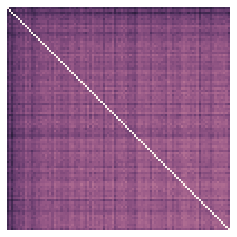

In [8]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
%matplotlib inline

def plot_timeseries(y, all_2015=all_2015):
    plt.plot(all_2015, y)
    plt.gcf().autofmt_xdate()
    plt.show()
    
minv = float('inf')
maxv = float('-inf')
max_2 = [0, 0]
min_2 = [0, 0]
for i in range(100):
    for j in range(100):
        if i == j:
            continue
        else:
            if matrix[i][j] > maxv:
                max_2 = [i, j]
                maxv = matrix[i][j]
            if matrix[i][j] < minv:
                min_2 = [i, j]
                minv = matrix[i][j]
            
plot_timeseries(user_timeseries[min_2[0]])
plot_timeseries(user_timeseries[min_2[1]])
plot_timeseries(user_timeseries[max_2[0]])
plot_timeseries(user_timeseries[max_2[1]])

    
sns.heatmap(matrix, xticklabels=False, yticklabels=False, linewidths=0, square=True,cbar=False)

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()